# Comparación de Modelos Clásicos de Machine Learning
Evaluación exhaustiva de modelos clásicos con diferentes técnicas de vectorización (TF-IDF, Bag of Words, etc.)

## Importar librerías

In [13]:
%pip install pyevall

Note: you may need to restart the kernel to use updated packages.


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score,
    precision_recall_fscore_support,
    roc_curve,
    auc,
    confusion_matrix
)
from scipy.sparse import hstack
import seaborn as sns

from pyevall.evaluation import PyEvALLEvaluation
from pyevall.metrics.metricfactory import MetricFactory

import warnings
warnings.filterwarnings('ignore')

## Configuración y parámetros

In [ ]:
MAIN_PATH = ".."
GROUP_ID = "BeingChillingWeWillWin"

TEXT_COLUMN = "text_clean" 
LABEL_COLUMN = "task1"

DATA_TRAIN_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "train_preprocessed_v2.json")
DATA_VAL_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "val_preprocessed_v2.json")
DATA_TEST_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "test_preprocessed_v2.json")

OUTPUT_DIR = os.path.join(MAIN_PATH, "results_v2", "clasicos")
PREDICTIONS_DIR = os.path.join(OUTPUT_DIR, "predictions")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

print(f"Configuración establecida:")
print(f"- Columna de texto: {TEXT_COLUMN}")
print(f"- Directorio de salida: {OUTPUT_DIR}")

Configuración establecida:
- Columna de texto: text_clean
- Directorio de salida: ../results/clasicos


## Carga y preprocesamiento de datos

In [16]:
train_df = pd.read_json(DATA_TRAIN_PATH)
val_df = pd.read_json(DATA_VAL_PATH)
test_df = pd.read_json(DATA_TEST_PATH)

label_map = {"NO": 0, "YES": 1}
label_map_inverse = {0: "NO", 1: "YES"}

train_df["label"] = train_df[LABEL_COLUMN].map(label_map)
val_df["label"] = val_df[LABEL_COLUMN].map(label_map)

print(f"Text column used: {TEXT_COLUMN}")
print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"\nDistribución de etiquetas en TRAIN:")
print(train_df[LABEL_COLUMN].value_counts())
print(f"\nDistribución de etiquetas en VAL:")
print(val_df[LABEL_COLUMN].value_counts())

Text column used: text_clean
Train size: 5154 | Val size: 910 | Test size: 934

Distribución de etiquetas en TRAIN:
task1
NO     2862
YES    2292
Name: count, dtype: int64

Distribución de etiquetas en VAL:
task1
NO     505
YES    405
Name: count, dtype: int64


## Preparación de Features

Probaremos diferentes técnicas de vectorización:
- **TF-IDF**: Term Frequency - Inverse Document Frequency
- **Bag of Words (BoW)**: Conteo simple de palabras (CountVectorizer)
- **Features numéricas**: estadísticas del texto (longitud, ratios, etc.)

In [17]:
# Features numéricas
numeric_features = [
    'word_count', 'avg_word_length', 'caps_ratio',
    'n_urls', 'n_mentions', 'n_hashtags', 'n_emojis',
    'n_exclamations', 'n_questions',
    'has_url', 'has_hashtag', 'has_mention', 'has_emoji'
]

# Extraer texto y labels
X_train_text = train_df[TEXT_COLUMN].fillna('')
X_val_text = val_df[TEXT_COLUMN].fillna('')
X_test_text = test_df[TEXT_COLUMN].fillna('')

y_train = train_df['label'].values
y_val = val_df['label'].values

print(f"Textos extraídos:")
print(f"- Train: {len(X_train_text)} samples")
print(f"- Val: {len(X_val_text)} samples")
print(f"- Test: {len(X_test_text)} samples")

Textos extraídos:
- Train: 5154 samples
- Val: 910 samples
- Test: 934 samples


### Vectorización con TF-IDF

In [18]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_val_tfidf = tfidf.transform(X_val_text)
X_test_tfidf = tfidf.transform(X_test_text)

print(f"TF-IDF shapes:")
print(f"- Train: {X_train_tfidf.shape}")
print(f"- Val: {X_val_tfidf.shape}")
print(f"- Test: {X_test_tfidf.shape}")
print(f"- Vocabulario: {len(tfidf.vocabulary_)} términos")

TF-IDF shapes:
- Train: (5154, 5000)
- Val: (910, 5000)
- Test: (934, 5000)
- Vocabulario: 5000 términos


### Vectorización con Bag of Words (CountVectorizer)

In [19]:
# Bag of Words (Count Vectorizer)
count_vec = CountVectorizer(
    max_features=5000, 
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_bow = count_vec.fit_transform(X_train_text)
X_val_bow = count_vec.transform(X_val_text)
X_test_bow = count_vec.transform(X_test_text)

print(f"Bag of Words shapes:")
print(f"- Train: {X_train_bow.shape}")
print(f"- Val: {X_val_bow.shape}")
print(f"- Test: {X_test_bow.shape}")
print(f"- Vocabulario: {len(count_vec.vocabulary_)} términos")

Bag of Words shapes:
- Train: (5154, 5000)
- Val: (910, 5000)
- Test: (934, 5000)
- Vocabulario: 5000 términos


### Features numéricas

In [20]:
# Features numéricas escaladas
scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[numeric_features])
X_val_num = scaler.transform(val_df[numeric_features])
X_test_num = scaler.transform(test_df[numeric_features])

print(f"Features numéricas shapes:")
print(f"- Train: {X_train_num.shape}")
print(f"- Val: {X_val_num.shape}")
print(f"- Test: {X_test_num.shape}")

Features numéricas shapes:
- Train: (5154, 13)
- Val: (910, 13)
- Test: (934, 13)


### Combinación de features

In [21]:
# Combinar TF-IDF + features numéricas
X_train_tfidf_combined = hstack([X_train_tfidf, X_train_num])
X_val_tfidf_combined = hstack([X_val_tfidf, X_val_num])
X_test_tfidf_combined = hstack([X_test_tfidf, X_test_num])

# Combinar BoW + features numéricas
X_train_bow_combined = hstack([X_train_bow, X_train_num])
X_val_bow_combined = hstack([X_val_bow, X_val_num])
X_test_bow_combined = hstack([X_test_bow, X_test_num])

print(f"\nFeatures combinadas (TF-IDF + numéricas):")
print(f"- Train: {X_train_tfidf_combined.shape}")
print(f"- Val: {X_val_tfidf_combined.shape}")
print(f"- Test: {X_test_tfidf_combined.shape}")

print(f"\nFeatures combinadas (BoW + numéricas):")
print(f"- Train: {X_train_bow_combined.shape}")
print(f"- Val: {X_val_bow_combined.shape}")
print(f"- Test: {X_test_bow_combined.shape}")


Features combinadas (TF-IDF + numéricas):
- Train: (5154, 5013)
- Val: (910, 5013)
- Test: (934, 5013)

Features combinadas (BoW + numéricas):
- Train: (5154, 5013)
- Val: (910, 5013)
- Test: (934, 5013)


## Definición de Modelos

Compararemos los siguientes tipos de modelos:
- **Lineales**: Logistic Regression, Linear SVC
- **Basados en árboles**: Decision Tree, Random Forest, Gradient Boosting
- **Probabilísticos**: Naive Bayes (Multinomial, Complement, Bernoulli)
- **Vecinos cercanos**: K-Nearest Neighbors
- **Ensembles**: Voting, Stacking, Bagging, AdaBoost

Evaluaremos cada modelo con **TF-IDF** y **Bag of Words**

In [22]:
def get_base_models():
    """Retorna diccionario con modelos base"""
    return {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, C=1.0),
        'LinearSVC': LinearSVC(max_iter=2000, random_state=42, C=0.1),
        'SVC_rbf': SVC(kernel='rbf', random_state=42, probability=True, C=1.0, gamma='scale'),
        'DecisionTree': DecisionTreeClassifier(max_depth=20, random_state=42, min_samples_split=10),
        'RandomForest': RandomForestClassifier(
            n_estimators=200, 
            max_depth=20, 
            random_state=42, 
            n_jobs=-1,
            min_samples_split=5
        ),
        'GradientBoosting': GradientBoostingClassifier(
            n_estimators=100, 
            max_depth=5, 
            learning_rate=0.1,
            random_state=42
        ),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42),
        'MultinomialNB': MultinomialNB(alpha=1.0),
        'ComplementNB': ComplementNB(alpha=1.0),
        'BernoulliNB': BernoulliNB(alpha=1.0),
        'KNN': KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1)
    }

def get_ensemble_models():
    """Retorna diccionario con modelos ensemble"""
    ensembles = {}
    
    # Voting Classifier (Hard)
    ensembles['VotingHard'] = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42))
        ],
        voting='hard',
        n_jobs=-1
    )
    
    # Voting Classifier (Soft)
    ensembles['VotingSoft'] = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42))
        ],
        voting='soft',
        n_jobs=-1
    )
    
    # Stacking Classifier
    ensembles['Stacking'] = StackingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42))
        ],
        final_estimator=LogisticRegression(max_iter=1000, random_state=42),
        n_jobs=-1
    )
    
    # Bagging con Decision Tree
    ensembles['Bagging_DT'] = BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=20, random_state=42),
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    )
    
    # Bagging con Logistic Regression
    ensembles['Bagging_LR'] = BaggingClassifier(
        estimator=LogisticRegression(max_iter=1000, random_state=42),
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    )
    
    return ensembles

# Obtener todos los modelos
base_models = get_base_models()
ensemble_models = get_ensemble_models()

all_models = {**base_models, **ensemble_models}

print(f"Total modelos a evaluar: {len(all_models)}")
print(f"- Modelos base: {len(base_models)}")
print(f"- Modelos ensemble: {len(ensemble_models)}")

Total modelos a evaluar: 16
- Modelos base: 11
- Modelos ensemble: 5


## Entrenamiento y Evaluación

Entrenamos cada modelo con ambas técnicas de vectorización (TF-IDF y BoW)

In [23]:
results = []

print("="*80)
print("ENTRENAMIENTO Y EVALUACIÓN DE MODELOS")
print("="*80)

for vectorization in ['TF-IDF', 'BoW']:
    print(f"\n{'='*80}")
    print(f"VECTORIZACIÓN: {vectorization}")
    print(f"{'='*80}\n")
    
    # Seleccionar features según vectorización
    if vectorization == 'TF-IDF':
        X_tr, X_v, X_tst = X_train_tfidf_combined, X_val_tfidf_combined, X_test_tfidf_combined
        X_tr_text, X_v_text, X_tst_text = X_train_tfidf, X_val_tfidf, X_test_tfidf
    else:  # BoW
        X_tr, X_v, X_tst = X_train_bow_combined, X_val_bow_combined, X_test_bow_combined
        X_tr_text, X_v_text, X_tst_text = X_train_bow, X_val_bow, X_test_bow
    
    for name, model in all_models.items():
        print(f"Entrenando {name} con {vectorization}...")
        
        try:
            # Naive Bayes requiere features no negativas (solo texto)
            if 'NB' in name:
                model.fit(X_tr_text, y_train)
                y_val_pred = model.predict(X_v_text)
                # Para probabilidades
                if hasattr(model, 'predict_proba'):
                    y_val_proba = model.predict_proba(X_v_text)[:, 1]
                else:
                    y_val_proba = None
            else:
                model.fit(X_tr, y_train)
                y_val_pred = model.predict(X_v)
                # Para probabilidades
                if hasattr(model, 'predict_proba'):
                    y_val_proba = model.predict_proba(X_v)[:, 1]
                elif hasattr(model, 'decision_function'):
                    y_val_proba = model.decision_function(X_v)
                else:
                    y_val_proba = None
            
            # Convertir predicciones a formato binario si es necesario
            y_val_pred_binary = (y_val_pred if isinstance(y_val_pred[0], (int, np.integer)) 
                                else (y_val_pred == 'YES').astype(int))
            
            # Métricas en validación
            acc_val = accuracy_score(y_val, y_val_pred_binary)
            precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
                y_val, y_val_pred_binary, average='binary', zero_division=0
            )
            
            # Calcular AUC si tenemos probabilidades
            auc_val = None
            if y_val_proba is not None:
                try:
                    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
                    auc_val = auc(fpr, tpr)
                except:
                    pass
            
            results.append({
                'Vectorization': vectorization,
                'Model': name,
                'Accuracy': acc_val,
                'Precision': precision_val,
                'Recall': recall_val,
                'F1': f1_val,
                'AUC': auc_val if auc_val else np.nan
            })
            
            # Formatear AUC correctamente
            auc_str = f"{auc_val:.4f}" if auc_val else "N/A"
            print(f"  ✓ Acc: {acc_val:.4f} | F1: {f1_val:.4f} | AUC: {auc_str}")
            
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            continue

print(f"\n{'='*80}")
print("✓ ENTRENAMIENTO COMPLETADO")
print(f"{'='*80}\n")

ENTRENAMIENTO Y EVALUACIÓN DE MODELOS

VECTORIZACIÓN: TF-IDF

Entrenando LogisticRegression con TF-IDF...
  ✓ Acc: 0.7637 | F1: 0.7160 | AUC: 0.8417
Entrenando LinearSVC con TF-IDF...
  ✓ Acc: 0.7648 | F1: 0.7162 | AUC: 0.8421
Entrenando SVC_rbf con TF-IDF...
  ✓ Acc: 0.6473 | F1: 0.5395 | AUC: 0.7091
Entrenando DecisionTree con TF-IDF...
  ✓ Acc: 0.7220 | F1: 0.6028 | AUC: 0.7221
Entrenando RandomForest con TF-IDF...
  ✓ Acc: 0.7220 | F1: 0.5978 | AUC: 0.8058
Entrenando GradientBoosting con TF-IDF...
  ✓ Acc: 0.7747 | F1: 0.7084 | AUC: 0.8306
Entrenando AdaBoost con TF-IDF...
  ✓ Acc: 0.6989 | F1: 0.5340 | AUC: 0.7278
Entrenando MultinomialNB con TF-IDF...
  ✓ Acc: 0.7308 | F1: 0.6797 | AUC: 0.7989
Entrenando ComplementNB con TF-IDF...
  ✓ Acc: 0.7297 | F1: 0.7015 | AUC: 0.7989
Entrenando BernoulliNB con TF-IDF...
  ✓ Acc: 0.7154 | F1: 0.6658 | AUC: 0.7882
Entrenando KNN con TF-IDF...
  ✓ Acc: 0.5703 | F1: 0.5119 | AUC: 0.5947
Entrenando VotingHard con TF-IDF...
  ✓ Acc: 0.7549 | F1: 

## Análisis de Resultados

In [24]:
results_df = pd.DataFrame(results)

# Mostrar top 10 modelos por F1
print("="*80)
print("TOP 10 MODELOS (ordenados por F1-Score)")
print("="*80)
print(results_df.sort_values('F1', ascending=False).head(10).to_string(index=False))
print()

# Comparar TF-IDF vs BoW
print("\n" + "="*80)
print("COMPARACIÓN: TF-IDF vs Bag of Words (promedio por modelo)")
print("="*80)
comparison = results_df.groupby('Vectorization')[['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']].mean()
print(comparison)
print()

TOP 10 MODELOS (ordenados por F1-Score)
Vectorization              Model  Accuracy  Precision   Recall       F1      AUC
       TF-IDF           Stacking  0.784615   0.789474 0.703704 0.744125 0.849138
          BoW           Stacking  0.773626   0.780282 0.683951 0.728947 0.848175
          BoW         Bagging_LR  0.767033   0.767313 0.683951 0.723238 0.841516
          BoW          LinearSVC  0.758242   0.742782 0.698765 0.720102 0.826662
       TF-IDF         Bagging_LR  0.764835   0.770538 0.671605 0.717678 0.838866
       TF-IDF          LinearSVC  0.764835   0.773639 0.666667 0.716180 0.842098
       TF-IDF LogisticRegression  0.763736   0.769886 0.669136 0.715984 0.841657
          BoW LogisticRegression  0.753846   0.740053 0.688889 0.713555 0.829468
          BoW   GradientBoosting  0.774725   0.833333 0.617284 0.709220 0.833377
       TF-IDF   GradientBoosting  0.774725   0.835570 0.614815 0.708393 0.830583


COMPARACIÓN: TF-IDF vs Bag of Words (promedio por modelo)
         

### Visualización de resultados

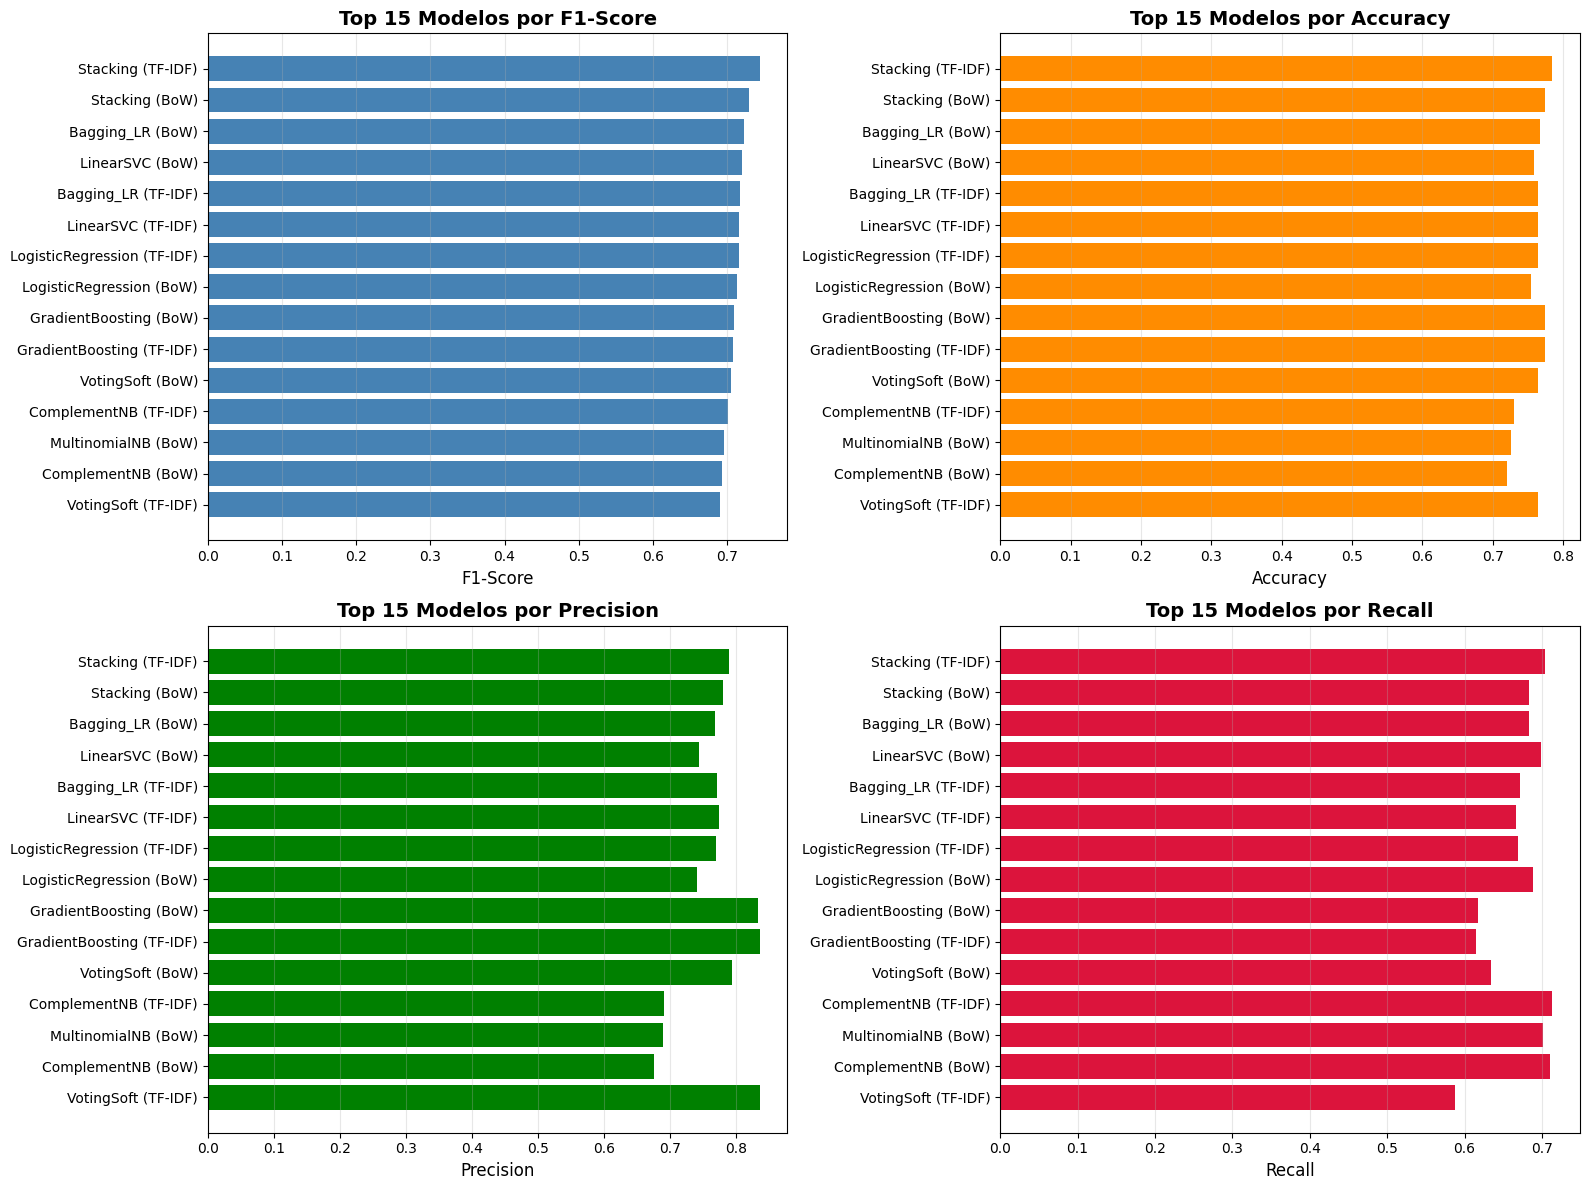

In [25]:
# Top 15 modelos por F1
top_15 = results_df.nlargest(15, 'F1').copy()
top_15['Model_Vec'] = top_15['Model'] + ' (' + top_15['Vectorization'] + ')'

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score
axes[0, 0].barh(top_15['Model_Vec'], top_15['F1'], color='steelblue')
axes[0, 0].set_xlabel('F1-Score', fontsize=12)
axes[0, 0].set_title('Top 15 Modelos por F1-Score', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# Accuracy
axes[0, 1].barh(top_15['Model_Vec'], top_15['Accuracy'], color='darkorange')
axes[0, 1].set_xlabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Top 15 Modelos por Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# Precision
axes[1, 0].barh(top_15['Model_Vec'], top_15['Precision'], color='green')
axes[1, 0].set_xlabel('Precision', fontsize=12)
axes[1, 0].set_title('Top 15 Modelos por Precision', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].invert_yaxis()

# Recall
axes[1, 1].barh(top_15['Model_Vec'], top_15['Recall'], color='crimson')
axes[1, 1].set_xlabel('Recall', fontsize=12)
axes[1, 1].set_title('Top 15 Modelos por Recall', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

### Comparación TF-IDF vs Bag of Words

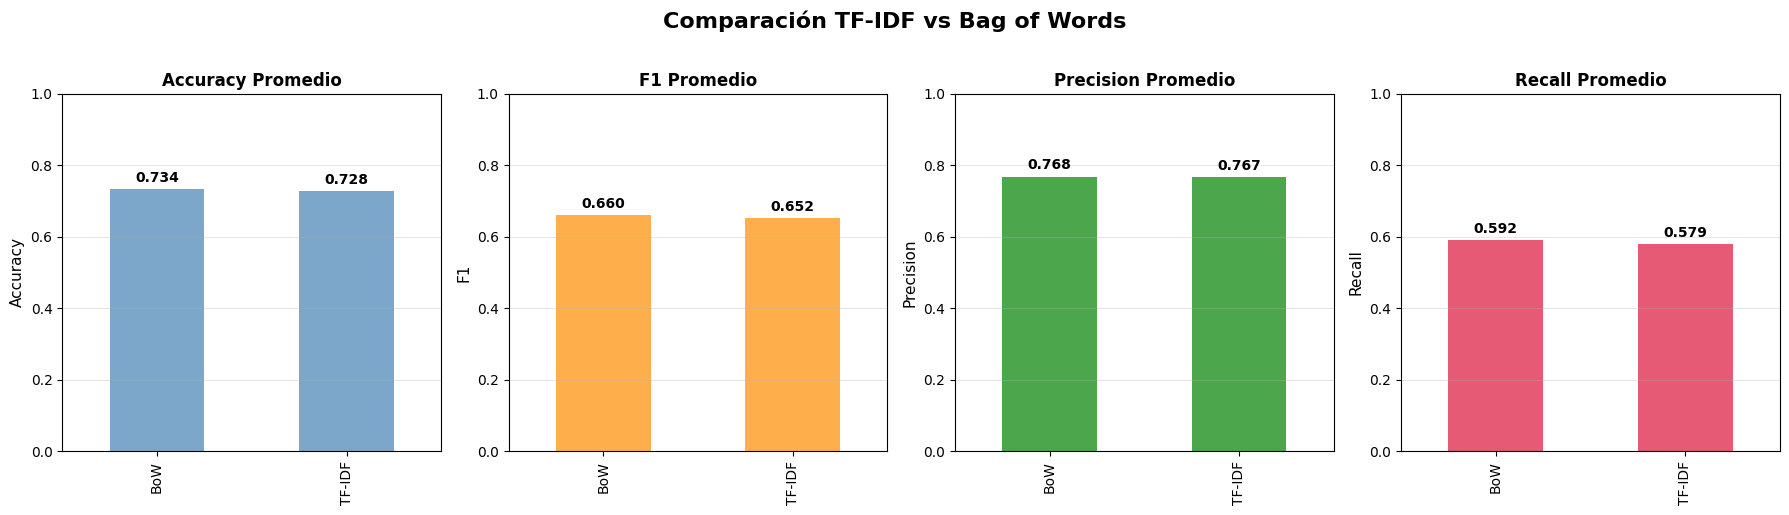

In [26]:
# Comparación visual TF-IDF vs BoW
fig, ax = plt.subplots(1, 4, figsize=(18, 5))

metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
colors = ['steelblue', 'darkorange', 'green', 'crimson']

comparison_data = results_df.groupby('Vectorization')[metrics].mean()

for i, (metric, color) in enumerate(zip(metrics, colors)):
    comparison_data[metric].plot(kind='bar', ax=ax[i], color=color, alpha=0.7)
    ax[i].set_title(f'{metric} Promedio', fontsize=12, fontweight='bold')
    ax[i].set_ylabel(metric, fontsize=11)
    ax[i].set_xlabel('')
    ax[i].grid(axis='y', alpha=0.3)
    ax[i].set_ylim([0, 1])
    
    # Añadir valores
    for j, v in enumerate(comparison_data[metric]):
        ax[i].text(j, v + 0.02, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Comparación TF-IDF vs Bag of Words', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Selección del Mejor Modelo y Análisis Detallado

In [27]:
# Guardar todos los resultados
results_df.to_csv(os.path.join(OUTPUT_DIR, 'model_comparison.csv'), index=False)
print(f"✓ Resultados guardados en {os.path.join(OUTPUT_DIR, 'model_comparison.csv')}")

# Seleccionar el mejor modelo basado en F1-Score
best_row = results_df.iloc[0]
best_model_name = best_row['Model']
best_vectorization = best_row['Vectorization']

print(f"\n{'='*80}")
print(f"MEJOR MODELO: {best_model_name} con {best_vectorization}")
print(f"{'='*80}")
print(f"F1-Score: {best_row['F1']:.4f}")
print(f"Accuracy: {best_row['Accuracy']:.4f}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
if not pd.isna(best_row['AUC']):
    print(f"AUC: {best_row['AUC']:.4f}")

✓ Resultados guardados en ../results/clasicos/model_comparison.csv

MEJOR MODELO: LogisticRegression con TF-IDF
F1-Score: 0.7160
Accuracy: 0.7637
Precision: 0.7699
Recall: 0.6691
AUC: 0.8417


## Re-entrenar el mejor modelo para análisis detallado

In [28]:
# Re-crear y entrenar el mejor modelo
from copy import deepcopy

# Determinar qué features usar
if best_vectorization == 'TF-IDF':
    X_train_best = X_train_tfidf_combined
    X_val_best = X_val_tfidf_combined
    X_test_best = X_test_tfidf_combined
    X_train_best_text = X_train_tfidf
    X_val_best_text = X_val_tfidf
    X_test_best_text = X_test_tfidf
else:
    X_train_best = X_train_bow_combined
    X_val_best = X_val_bow_combined
    X_test_best = X_test_bow_combined
    X_train_best_text = X_train_bow
    X_val_best_text = X_val_bow
    X_test_best_text = X_test_bow

# Obtener el modelo
if best_model_name in base_models:
    best_model = get_base_models()[best_model_name]
elif best_model_name in ensemble_models:
    best_model = get_ensemble_models()[best_model_name]

print(f"Entrenando {best_model_name} con {best_vectorization}...")

# Entrenar
if 'NB' in best_model_name:
    best_model.fit(X_train_best_text, y_train)
    y_val_pred = best_model.predict(X_val_best_text)
    y_test_pred = best_model.predict(X_test_best_text)
    
    if hasattr(best_model, 'predict_proba'):
        y_val_proba = best_model.predict_proba(X_val_best_text)[:, 1]
        y_test_proba = best_model.predict_proba(X_test_best_text)[:, 1]
    else:
        y_val_proba = None
        y_test_proba = None
else:
    best_model.fit(X_train_best, y_train)
    y_val_pred = best_model.predict(X_val_best)
    y_test_pred = best_model.predict(X_test_best)
    
    if hasattr(best_model, 'predict_proba'):
        y_val_proba = best_model.predict_proba(X_val_best)[:, 1]
        y_test_proba = best_model.predict_proba(X_test_best)[:, 1]
    elif hasattr(best_model, 'decision_function'):
        y_val_proba = best_model.decision_function(X_val_best)
        y_test_proba = best_model.decision_function(X_test_best)
    else:
        y_val_proba = None
        y_test_proba = None

print("✓ Modelo entrenado")

Entrenando LogisticRegression con TF-IDF...
✓ Modelo entrenado


## Curva ROC y Optimización de Threshold

AUC (VAL): 0.8417
Threshold óptimo: 0.4493
TPR en threshold óptimo: 0.7605
FPR en threshold óptimo: 0.2198

Métricas en VAL con threshold óptimo (0.4493):
Accuracy: 0.7714
Precision: 0.7351
Recall: 0.7605
F1-Score: 0.7476


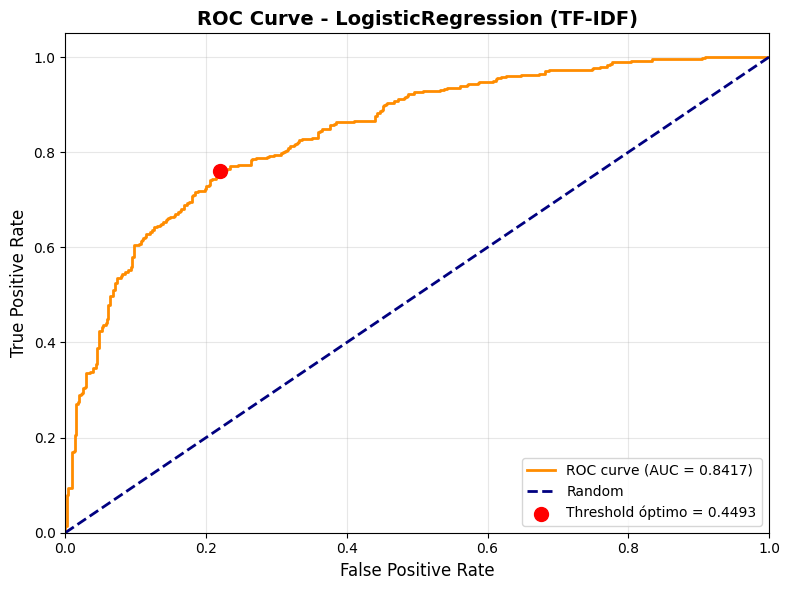

In [29]:
if y_val_proba is not None:
    # Calcular ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)
    
    # Encontrar threshold óptimo (máxima diferencia TPR - FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"AUC (VAL): {roc_auc:.4f}")
    print(f"Threshold óptimo: {optimal_threshold:.4f}")
    print(f"TPR en threshold óptimo: {tpr[optimal_idx]:.4f}")
    print(f"FPR en threshold óptimo: {fpr[optimal_idx]:.4f}")
    
    # Aplicar threshold óptimo
    y_val_pred_optimal = (y_val_proba >= optimal_threshold).astype(int)
    
    # Métricas con threshold óptimo
    precision_opt, recall_opt, f1_opt, _ = precision_recall_fscore_support(
        y_val, y_val_pred_optimal, average='binary', zero_division=0
    )
    acc_opt = accuracy_score(y_val, y_val_pred_optimal)
    
    print(f"\nMétricas en VAL con threshold óptimo ({optimal_threshold:.4f}):")
    print(f"Accuracy: {acc_opt:.4f}")
    print(f"Precision: {precision_opt:.4f}")
    print(f"Recall: {recall_opt:.4f}")
    print(f"F1-Score: {f1_opt:.4f}")
    
    # Visualizar ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red',
                label=f'Threshold óptimo = {optimal_threshold:.4f}', s=100, zorder=5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {best_model_name} ({best_vectorization})', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Usar threshold óptimo para predicciones
    y_val_pred_final = y_val_pred_optimal
    if y_test_proba is not None:
        y_test_pred_final = (y_test_proba >= optimal_threshold).astype(int)
    else:
        y_test_pred_final = y_test_pred
else:
    print("El modelo no soporta probabilidades, usando predicciones directas")
    optimal_threshold = 0.5
    y_val_pred_final = y_val_pred
    y_test_pred_final = y_test_pred

## Matriz de Confusión

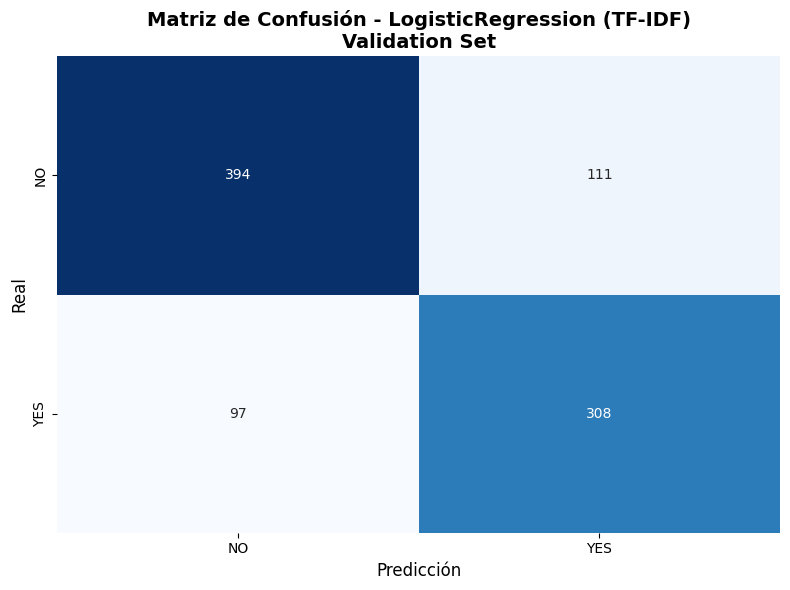


Classification Report (Validation):
              precision    recall  f1-score   support

          NO       0.80      0.78      0.79       505
         YES       0.74      0.76      0.75       405

    accuracy                           0.77       910
   macro avg       0.77      0.77      0.77       910
weighted avg       0.77      0.77      0.77       910



In [30]:
# Matriz de confusión en validación
cm = confusion_matrix(y_val, y_val_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.title(f'Matriz de Confusión - {best_model_name} ({best_vectorization})\nValidation Set', 
          fontsize=14, fontweight='bold')
plt.ylabel('Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred_final, target_names=['NO', 'YES']))

## Evaluación en VAL con PyEvALL

In [31]:
# Preparar predicciones para PyEvALL
val_preds_for_pyevall = []
for id_exist, pred in zip(val_df['id_EXIST'].values, y_val_pred_final):
    val_preds_for_pyevall.append({
        'test_case': 'EXIST2025',
        'id': str(id_exist),
        'value': label_map_inverse[pred]
    })

val_preds_df = pd.DataFrame(val_preds_for_pyevall)
val_preds_path = os.path.join(PREDICTIONS_DIR, 'val_predictions_temp.json')
with open(val_preds_path, 'w', encoding='utf-8') as f:
    f.write(val_preds_df.to_json(orient='records'))

# Preparar gold standard
val_gold = []
for id_exist, label in zip(val_df['id_EXIST'].values, val_df[LABEL_COLUMN].values):
    val_gold.append({
        'test_case': 'EXIST2025',
        'id': str(id_exist),
        'value': label
    })

val_gold_df = pd.DataFrame(val_gold)
val_gold_path = os.path.join(PREDICTIONS_DIR, 'val_gold_temp.json')
with open(val_gold_path, 'w', encoding='utf-8') as f:
    f.write(val_gold_df.to_json(orient='records'))

# Evaluar con PyEvALL
test = PyEvALLEvaluation()
metrics = [
    MetricFactory.Accuracy.value,
    MetricFactory.FMeasure.value,
]
params = dict()
report = test.evaluate(val_preds_path, val_gold_path, metrics, **params)
print("\n" + "="*80)
print("EVALUACIÓN EN VAL CON PyEvALL")
print("="*80)
report.print_report()

2026-02-26 10:20:15,553 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['Accuracy', 'FMeasure']
2026-02-26 10:20:15,600 - pyevall.metrics.metrics - INFO -             evaluate() - Executing accuracy evaluation method
2026-02-26 10:20:15,714 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method

EVALUACIÓN EN VAL CON PyEvALL
{
  "metrics": {
    "Accuracy": {
      "name": "Accuracy",
      "acronym": "Acc",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "average": 0.7714285714285715
        }],
        "average_per_test_case": 0.7714285714285715
      }
    },
    "FMeasure": {
      "name": "F-Measure",
      "acronym": "F1",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "classes": {
            "NO": 0.7911646

## Inferencia en TEST y Generación de Predicciones Finales


Predicciones en TEST (con threshold=0.4493):
Total muestras: 934
Predicciones YES: 433 (46.36%)
Predicciones NO: 501 (53.64%)


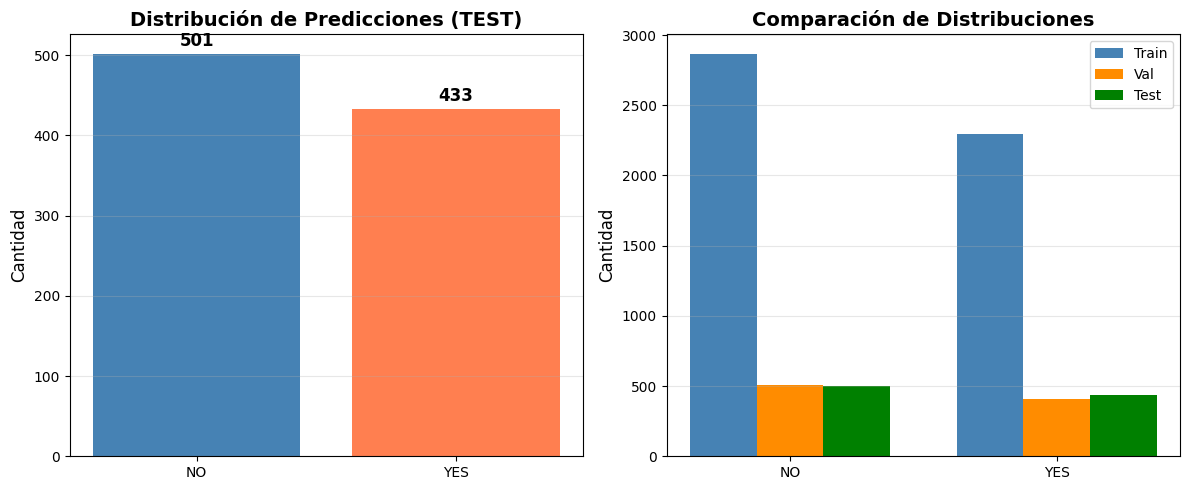

In [32]:
print(f"\nPredicciones en TEST (con threshold={optimal_threshold:.4f}):")
print(f"Total muestras: {len(y_test_pred_final)}")
print(f"Predicciones YES: {np.sum(y_test_pred_final == 1)} ({100*np.mean(y_test_pred_final == 1):.2f}%)")
print(f"Predicciones NO: {np.sum(y_test_pred_final == 0)} ({100*np.mean(y_test_pred_final == 0):.2f}%)")

# Distribución de predicciones
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Distribución en TEST
test_dist = pd.Series(y_test_pred_final).map(label_map_inverse).value_counts()
ax[0].bar(test_dist.index, test_dist.values, color=['steelblue', 'coral'])
ax[0].set_title('Distribución de Predicciones (TEST)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Cantidad', fontsize=12)
ax[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_dist.values):
    ax[0].text(i, v + 10, str(v), ha='center', fontsize=12, fontweight='bold')

# Comparación TRAIN vs VAL vs TEST
train_dist = train_df[LABEL_COLUMN].value_counts()
val_dist = val_df[LABEL_COLUMN].value_counts()

x = np.arange(2)
width = 0.25

ax[1].bar(x - width, [train_dist.get('NO', 0), train_dist.get('YES', 0)], width, label='Train', color='steelblue')
ax[1].bar(x, [val_dist.get('NO', 0), val_dist.get('YES', 0)], width, label='Val', color='darkorange')
ax[1].bar(x + width, [test_dist.get('NO', 0), test_dist.get('YES', 0)], width, label='Test', color='green')

ax[1].set_title('Comparación de Distribuciones', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Cantidad', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(['NO', 'YES'])
ax[1].legend()
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Guardar Predicciones en Formato PyEvALL para TEST

In [33]:
# Crear identificador del modelo
model_name_clean = best_model_name.replace('_', '').replace(' ', '')
vectorization_short = 'TFIDF' if best_vectorization == 'TF-IDF' else 'BoW'
MODEL_ID = f"{model_name_clean}_{vectorization_short}"

# Preparar predicciones para submission
test_preds_for_submission = []
for id_exist, pred in zip(test_df['id_EXIST'].values, y_test_pred_final):
    test_preds_for_submission.append({
        'test_case': 'EXIST2025',
        'id': str(id_exist),
        'value': label_map_inverse[pred]
    })

test_preds_df = pd.DataFrame(test_preds_for_submission)

output_filename = f"{GROUP_ID}_{MODEL_ID}.json"
output_path = os.path.join(OUTPUT_DIR, output_filename)

with open(output_path, 'w', encoding='utf-8') as output_file:
    output_file.write(test_preds_df.to_json(orient='records'))

print(f"\n{'='*80}")
print(f"✓ PREDICCIONES GUARDADAS")
print(f"{'='*80}")
print(f"Archivo: {output_path}")
print(f"Modelo: {best_model_name}")
print(f"Vectorización: {best_vectorization}")
print(f"Total predicciones: {len(test_preds_df)}")


✓ PREDICCIONES GUARDADAS
Archivo: ../results/clasicos/BeingChillingWeWillWin_LogisticRegression_TFIDF.json
Modelo: LogisticRegression
Vectorización: TF-IDF
Total predicciones: 934


## Resumen Final

In [34]:
print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)
print(f"\nMejor modelo: {best_model_name}")
print(f"Vectorización: {best_vectorization}")
print(f"Threshold óptimo: {optimal_threshold:.4f}")
print(f"\nMétricas en Validación:")
print(f"  - Accuracy:  {acc_opt:.4f}")
print(f"  - Precision: {precision_opt:.4f}")
print(f"  - Recall:    {recall_opt:.4f}")
print(f"  - F1-Score:  {f1_opt:.4f}")
if y_val_proba is not None:
    print(f"  - AUC:       {roc_auc:.4f}")
print(f"\nArchivos generados:")
print(f"  - Comparación de modelos: {os.path.join(OUTPUT_DIR, 'model_comparison.csv')}")
print(f"  - Predicciones TEST: {output_path}")
print("\n" + "="*80)
print("✓ PROCESO COMPLETADO")
print("="*80)


RESUMEN FINAL

Mejor modelo: LogisticRegression
Vectorización: TF-IDF
Threshold óptimo: 0.4493

Métricas en Validación:
  - Accuracy:  0.7714
  - Precision: 0.7351
  - Recall:    0.7605
  - F1-Score:  0.7476
  - AUC:       0.8417

Archivos generados:
  - Comparación de modelos: ../results/clasicos/model_comparison.csv
  - Predicciones TEST: ../results/clasicos/BeingChillingWeWillWin_LogisticRegression_TFIDF.json

✓ PROCESO COMPLETADO
